## Download the EuroSAT RGB data
---



In [1]:
!pip install zenodo-get

!zenodo_get 10.5281/zenodo.7711810 -g "EuroSAT_RGB.zip"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.6/250.6 kB 27.3 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=e6383315f95462f59a4adbad80b02b370f0cce7705c33f629b11ee10f1b6dfaf
  Stored in directory: /root/.cache/pip/wheels/01/46/3b/e29ffbe4ebe614ff224bad40fc6a5773a67a163251585a13a9
Successfully built wget
Title: EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification
Keywords: remote sensing, earth observation, land cover classification, land use classification, satellite images, sentinel-2, machine learning, deep learning, deep convolutional neural network
Publication date: 2018-07-22
DOI: 10.5281/zenodo.7711810
Total size: 94.7 MB

File: EuroSAT_RGB.zip (94.7 MB)
Link: https://zenodo.org/api/records/7711810/files/EuroSAT_RGB.zip/content

Checksum is correct for EuroSAT_RGB.zip. 

## Import necessary libraries

In [1]:
import zipfile
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

from PIL import Image

import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

import torch.optim as optim

from IPython.display import clear_output

## Specify the wanted parameters

In [17]:
batch_size = 2500 #sets the batch_size for data loading & training
num_epochs = 100 #highest number of epochs to run
early_stop = 10 #stops if val loss has not improved over 5 epochs
PATH = './best_model.pth'


## Extract the zip

In [4]:
# Define the path to your zip file
zip_file_path = './EuroSAT_RGB.zip'

extract_to_directory = './'

try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to_directory)
    print(f"Successfully extracted all contents of '{zip_file_path}' to '{extract_to_directory}'")
except zipfile.BadZipFile:
    print(f"Error: '{zip_file_path}' is not a valid zip file.")
except FileNotFoundError:
    print(f"Error: Zip file '{zip_file_path}' not found.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Successfully extracted all contents of './EuroSAT_RGB.zip' to './'


In [3]:

# Gather all image file paths
image_dir = './EuroSAT_RGB/'
all_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir)]

all_files = []
labels = []

for path in all_paths:
  all_files.extend([os.path.join(path, f) for f in os.listdir(path)])
  index = path.find('EuroSAT_RGB/')
  if index != -1:
      start_index = index + len('EuroSAT_RGB/')
      result = path[start_index:]
  else:
      result = "" # Target string not found
  labels.extend([result] * len(os.listdir(path)))

# Get labels (assuming class names are part of the file paths)
labels = [os.path.basename(os.path.dirname(f)) for f in all_files]

# Example categorical data
categories = np.unique(labels)
labels_map = {category: i for i, category in enumerate(categories)}

# Initialize and fit LabelEncoder
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)



# Convert to PyTorch tensor
encoded_tensor = torch.tensor(encoded_labels, dtype=torch.long)

print(f"Original categories: {categories}")
print(f"Encoded labels: {encoded_labels}")
print(f"PyTorch tensor: {encoded_tensor}")


Original categories: ['AnnualCrop' 'Forest' 'HerbaceousVegetation' 'Highway' 'Industrial'
 'Pasture' 'PermanentCrop' 'Residential' 'River' 'SeaLake']
Encoded labels: [4 4 4 ... 2 2 2]
PyTorch tensor: tensor([4, 4, 4,  ..., 2, 2, 2])


#Check dimensions of image data

In [4]:
# Load the image
image = Image.open('./EuroSAT_RGB/HerbaceousVegetation/HerbaceousVegetation_1.jpg')

image_array = np.asarray(image)

# Print the type and shape of the resulting NumPy array
print(f"Type of image_array: {type(image_array)}")
print(f"Shape of image_array: {image_array.shape}")

Type of image_array: <class 'numpy.ndarray'>
Shape of image_array: (64, 64, 3)


## Calculate the mean and stdev of each pixel (RGB) within our sateillite dataset

In [5]:
# use this transform until we can normalize
transform = transforms.Compose([transforms.Resize((64, 64)),
                                transforms.ToTensor()])
dataset = ImageFolder(root='./EuroSAT_RGB', transform = transform)
total_loader = DataLoader(dataset, batch_size = batch_size, shuffle = False, num_workers = 1)

def get_mean_stdev(loader):
    # Compute mean and stdev of all pixels in dataset
    num_images = 0
    mean = torch.zeros(3)
    var = torch.zeros(3)
    num_pixels = 0

    for images, _ in loader:
        batch_size, num_channels, height, width = images.shape
        num_pixels += batch_size * height * width
        mean += images.sum(dim=[0,2,3])

    mean = mean/num_pixels

    for images, _ in loader:
        batch_size, num_channels, height, width = images.shape
        var += ((images - mean[None, :, None, None])**2).sum(dim=[0,2,3])

    var = var/num_pixels
    stdev = torch.sqrt(var)
    return mean, stdev

mean, stdev = get_mean_stdev(total_loader)
print(f'mean: {mean}, stdev: {stdev}')


mean: tensor([0.3444, 0.3803, 0.4078]), stdev: tensor([0.2027, 0.1369, 0.1156])


## Specify the transformations to be applied to each image

In [6]:
transform = transforms.Compose([transforms.Resize((64, 64)), # resize the images to ensure 64x64 pixels         # Convert PIL Image to PyTorch Tensor])
transforms.ToTensor(), #convert to a tensor
transforms.Normalize(mean=mean, std=stdev)])

## Split dataset into train, val, test

In [7]:
dataset = ImageFolder(root='./EuroSAT_RGB', transform = transform)

indices = list(range(len(dataset)))
labels = dataset.targets

train_idx, temp_idx, train_labels, temp_labels = train_test_split(indices,
                                       labels, test_size = 0.2,
                                       stratify = labels, random_state = 69)

val_idx, test_idx, val_labels, test_labels = train_test_split(temp_idx, temp_labels, test_size=0.5, stratify = temp_labels, random_state = 69 )

train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Set-up pytorch dataloaders

In [18]:
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, num_workers = 1)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=True, num_workers = 1)
test_loader = DataLoader(test_dataset, shuffle=True, batch_size = batch_size, num_workers = 1)

## Specify the model
CNN documentation: https://docs.pytorch.org/tutorials/recipes/recipes/defining_a_neural_network.html

'Attention is all you need'
https://arxiv.org/pdf/1706.03762

In [64]:
torch.cuda.empty_cache()

In [19]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # output 32 convolutional features with square kernel of size 3
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, stride = 1, padding=1)
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 1)

        # Designed to ensure that adjacent pixels are either all 0s or all active with an input probability
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)

        # Maxpool 2D takes in (Cin, Hin, Win), outputs (C, Hout, Wout). If do 2,
        #stride=2, then will divide both H, W dimensions by 2
        self.fc1 = nn.Linear(64 * 32 * 32, 1024)

        # to fit to the labels
        self.fc2 = nn.Linear(1024, 10)

        #transformer layer
        self.transformer = nn.TransformerEncoderLayer(d_model = 64, nhead = 8, dim_feedforward=256)

    # x represents our data
    def forward(self, x):

        # F is from the torch.nn.Functional library (don't require parameters)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)

        # Run max pooling over x
        x = F.max_pool2d(x,2)

        # prevent overfitting
        x = self.dropout1(x)

        B, C, H, W = x.shape
        x = x.view(B, C, H*W)       #resize so all pixels are concatenated
        x = x.permute(2,0,1)        #H*W, B, C
        x = self.transformer(x)       # apply transformer layer
        x = x.permute(1, 2, 0)       # [B, C, H*W]
        x = x.view(B, C, H, W)      # [B, 64, 32, 32]

        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = F.relu(x)

        x = self.dropout2(x)
        x = self.fc2(x)

        #soft-max to the labels
        output = F.log_softmax(x, dim=1)
        return output

model = CNN()
model.to(device)
print(model)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=65536, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
  (transformer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
    )
    (linear1): Linear(in_features=64, out_features=256, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=256, out_features=64, bias=True)
    (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
)


In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

Epoch 49/100, Train Loss: 0.4019, Val Loss: 0.5943


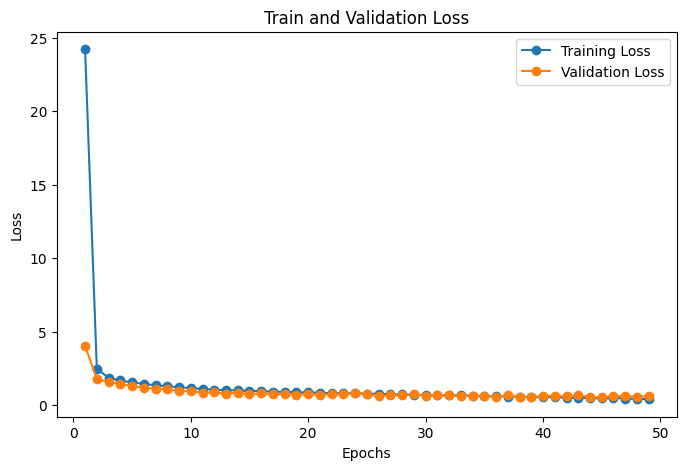

Early stopping criterion met


In [21]:
train_losses = []
val_losses = []

best_val_loss = float('inf') #initialize with a high value
count = 0


for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0

  # training loop
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device) # move to device

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader) #average train loss
    train_losses.append(avg_train_loss)

    # validation loop
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    clear_output(wait=True)  # clears previous plot output
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    plt.figure(figsize=(8,5))
    plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss', marker = 'o')
    plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss', marker = 'o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Train and Validation Loss, Best Validation Loss: {best_val_loss}')
    plt.show()

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        count = 0
        torch.save(model.state_dict(), PATH)
    else:
        count += 1
        if count >= early_stop:
            print(f'Early stopping criterion met')
            break



In [22]:
model = CNN()
model.load_state_dict(torch.load(PATH, weights_only=True))
model.to(device)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=65536, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
  (transformer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
    )
    (linear1): Linear(in_features=64, out_features=256, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=256, out_features=64, bias=True)
    (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
)

In [23]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')


Accuracy of the network on the 10000 test images: 80 %


In [24]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in categories}
total_pred = {classname:0. for classname in categories}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect correct predictions for each class

        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[categories[label]] += 1
            total_pred[categories[label]] += 1

#print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f' Accuracy for class {classname:.5s} is {accuracy:.1f} %')

 Accuracy for class Annua is 87.7 %
 Accuracy for class Fores is 89.0 %
 Accuracy for class Herba is 70.0 %
 Accuracy for class Highw is 57.2 %
 Accuracy for class Indus is 92.8 %
 Accuracy for class Pastu is 72.5 %
 Accuracy for class Perma is 56.8 %
 Accuracy for class Resid is 94.7 %
 Accuracy for class River is 71.6 %
 Accuracy for class SeaLa is 91.7 %
